In [7]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    PrecisionRecallDisplay
)

# --- Configuration ---
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH   = DATA_DIR / "vm_val.parquet"
TEST_PATH  = DATA_DIR / "vm_test.parquet"

TARGET_COL = "critical"

In [2]:
# 1. Load Data Splits
# ------------------------------------------------------------------------------
print("Loading split files...")

# Load directly into Polars
df_train = pl.read_parquet(TRAIN_PATH)
df_val   = pl.read_parquet(VAL_PATH)
df_test  = pl.read_parquet(TEST_PATH)

print(f"Train rows: {df_train.height}")
print(f"Val   rows: {df_val.height}")
print(f"Test  rows: {df_test.height}")

Loading split files...
Train rows: 632426
Val   rows: 130005
Test  rows: 131849


In [3]:
# 2. Define Feature Selection (Leakage Removal)
# ------------------------------------------------------------------------------
# We define the columns to DROP to prevent data leakage.
# These include future timestamps, post-execution CPU stats, and label components.

DROP_COLS = {
    # ID & Time
    "vm_id", "subscription_id", "deployment_id", 
    "ts_vm_created", "ts_vm_deleted", "ts_first_vm_created",
    "split",  # Drop split column if it exists in the files
    
    # Target
    TARGET_COL,
    
    # Label Components & Future Info (LEAKAGE)
    "lifetime_sec", "lifetime_hours", "long_lived",
    "max_cpu", "avg_cpu", "p95_max_cpu", "n_readings", "max_cpu_right",
    "cpu_mean", "cpu_std", "cpu_frac_gt_60", "cpu_frac_gt_80",
    "day_cpu_mean", "night_cpu_mean", "day_night_ratio",
    "sustained_high", "strong_diurnal"
}

# Add all hourly CPU columns dynamically
hourly_cpu_cols = [c for c in df_train.columns if c.startswith("cpu_hour_")]
DROP_COLS.update(hourly_cpu_cols)

# Define feature list based on what remains (Static + History)
# We inspect columns from df_train to ensure consistency
ALL_COLS = set(df_train.columns)
FEATURE_COLS = list(ALL_COLS - DROP_COLS)

# Separate into Numeric and Categorical for the pipeline
CATEGORICAL_COLS = ["vm_category"]
NUMERIC_COLS = [c for c in FEATURE_COLS if c not in CATEGORICAL_COLS]

print(f"\nTraining with {len(FEATURE_COLS)} features.")
print(f"Categorical: {CATEGORICAL_COLS}")
print(f"Numeric examples: {NUMERIC_COLS[:5]}")


Training with 21 features.
Categorical: ['vm_category']
Numeric examples: ['hour_of_day', 'sub_first_hour', 'vm_virtual_core_count', 'hist_n_critical', 'hist_lifetime_std']


In [4]:
# 3. Prepare X and y (Convert to Pandas)
# ------------------------------------------------------------------------------
def to_pandas_xy(df_polars):
    # Select features and target, convert to pandas
    X = df_polars.select(FEATURE_COLS).to_pandas()
    y = df_polars.select(TARGET_COL).to_pandas().values.ravel()
    return X, y

X_train, y_train = to_pandas_xy(df_train)
X_val, y_val     = to_pandas_xy(df_val)
X_test, y_test   = to_pandas_xy(df_test)

print(f"\nClass Balance (Positive Rate):")
print(f"Train: {y_train.mean():.2%}")
print(f"Val:   {y_val.mean():.2%}")


Class Balance (Positive Rate):
Train: 2.62%
Val:   3.04%


In [8]:
# 3. Build Preprocessing and Modeling Pipeline (Corrected)
# ------------------------------------------------------------------------------

# Define a pipeline for NUMERIC features:
# 1. Impute missing values with the Median (robust to outliers)
# 2. Scale features (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

# Define a pipeline for CATEGORICAL features:
# 1. Impute missing values with a constant "Unknown" placeholder
# 2. One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine them into the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_COLS),
        ('cat', categorical_transformer, CATEGORICAL_COLS)
    ]
)

# Logistic Regression Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000, 
        solver='lbfgs', 
        random_state=42
    ))
])

print("Pipeline built successfully (with Imputation).")

Pipeline built successfully (with Imputation).


In [9]:
# 5. Train
# ------------------------------------------------------------------------------
print("\nTraining Logistic Regression Model...")
model.fit(X_train, y_train)
print("Done.")


Training Logistic Regression Model...
Done.



--- Validation Results ---
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    126056
           1       0.13      0.90      0.23      3949

    accuracy                           0.82    130005
   macro avg       0.56      0.86      0.56    130005
weighted avg       0.97      0.82      0.87    130005

ROC AUC: 0.8981


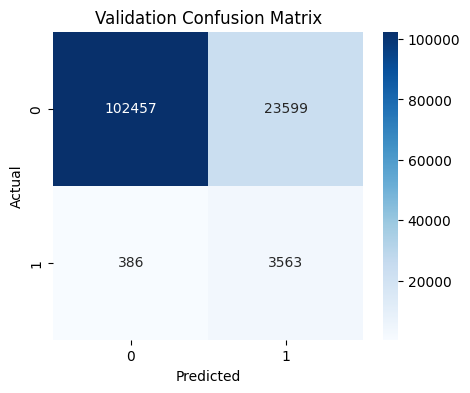

In [10]:
# 6. Evaluate on Validation
# ------------------------------------------------------------------------------
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]

print("\n--- Validation Results ---")
print(classification_report(y_val, y_val_pred))
print(f"ROC AUC: {roc_auc_score(y_val, y_val_prob):.4f}")

# Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [11]:
# 7. Evaluate on Test (Final Check)
# ------------------------------------------------------------------------------
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:, 1]

print("\n--- Test Results ---")
print(classification_report(y_test, y_test_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_test_prob):.4f}")


--- Test Results ---
              precision    recall  f1-score   support

           0       1.00      0.81      0.89    128977
           1       0.09      0.85      0.16      2872

    accuracy                           0.81    131849
   macro avg       0.54      0.83      0.53    131849
weighted avg       0.98      0.81      0.88    131849

ROC AUC: 0.8757


In [12]:
# 8. Feature Importance
# ------------------------------------------------------------------------------
# Get feature names back from the preprocessor
ohe_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(CATEGORICAL_COLS)
feature_names = NUMERIC_COLS + list(ohe_names)

coeffs = model.named_steps['classifier'].coef_[0]

importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coeffs,
    'Abs_Coeff': np.abs(coeffs)
}).sort_values(by='Abs_Coeff', ascending=False)

print("\nTop 10 Most Influential Features:")
print(importance[['Feature', 'Coefficient']].head(10))


Top 10 Most Influential Features:
                          Feature  Coefficient
5                    vm_memory_gb    -1.391530
17             hist_cpu_mean_mean     1.361522
7                 vm_mem_per_core     0.801186
11             hist_critical_frac     0.703879
22             vm_category_Unkown    -0.652894
18            hist_frac_gt60_mean    -0.469232
12      hist_day_night_ratio_mean    -0.436106
20  vm_category_Delay-insensitive    -0.394843
4               hist_lifetime_std     0.354457
13                  hist_p95_mean     0.337863
